# UTS (Ultimate Tensile Strength) Prediction

## Why Predict UTS from Yield Strength?

**Strong Correlation**: UTS and Yield Strength are highly correlated mechanical properties in welded materials. In most steels, UTS is typically 1.2-1.5 times the Yield Strength.

**Strategy**: Since we already have a trained SVR model for Yield Strength prediction (Test R² ≈ 0.77), we can leverage this correlation to predict UTS using:

1. **Direct correlation analysis** between YS and UTS
2. **Same features approach**: Train UTS model using same PCA components
3. **Best model identified**: SVR showed excellent performance for Yield Strength

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

## Load Data and Explore Correlation

In [ ]:
# Load the standardized dataset
df = pd.read_csv('../../welddatabase/welddb_pca.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()[:10]}...")  # Show first 10 columns

Dataset shape: (1652, 52)

Columns: ['Carbon_%', 'Silicon_%', 'Manganese_%', 'Sulphur_%', 'Phosphorus_%', 'Nickel_%', 'Chromium_%', 'Molybdenum_%', 'Vanadium_%', 'Copper_%']...


In [3]:
# Check data availability for both properties
ys_available = df['Yield_Strength_MPa'].notna().sum()
uts_available = df['UTS_MPa'].notna().sum()
both_available = df[df['Yield_Strength_MPa'].notna() & df['UTS_MPa'].notna()].shape[0]

print(f"Yield Strength available: {ys_available} ({ys_available/len(df)*100:.1f}%)")
print(f"UTS available: {uts_available} ({uts_available/len(df)*100:.1f}%)")
print(f"Both available: {both_available} ({both_available/len(df)*100:.1f}%)")

Yield Strength available: 780 (47.2%)
UTS available: 738 (44.7%)
Both available: 714 (43.2%)


## Correlation Analysis: Yield Strength vs UTS

In [4]:
# Filter samples with both YS and UTS
df_both = df[df['Yield_Strength_MPa'].notna() & df['UTS_MPa'].notna()].copy()

ys_values = df_both['Yield_Strength_MPa']
uts_values = df_both['UTS_MPa']

# Calculate correlation
correlation, p_value = pearsonr(ys_values, uts_values)

print(f"Samples with both properties: {len(df_both)}")
print(f"\nPearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"\nCorrelation Interpretation:")
if correlation > 0.9:
    print("  ✅ Very Strong Positive Correlation")
elif correlation > 0.7:
    print("  ✅ Strong Positive Correlation")
elif correlation > 0.5:
    print("  🟡 Moderate Positive Correlation")
else:
    print("  ⚠️ Weak Correlation")

Samples with both properties: 714

Pearson Correlation: 0.9155
P-value: 1.12e-283

Correlation Interpretation:
  ✅ Very Strong Positive Correlation


## Visualization: YS vs UTS Relationship

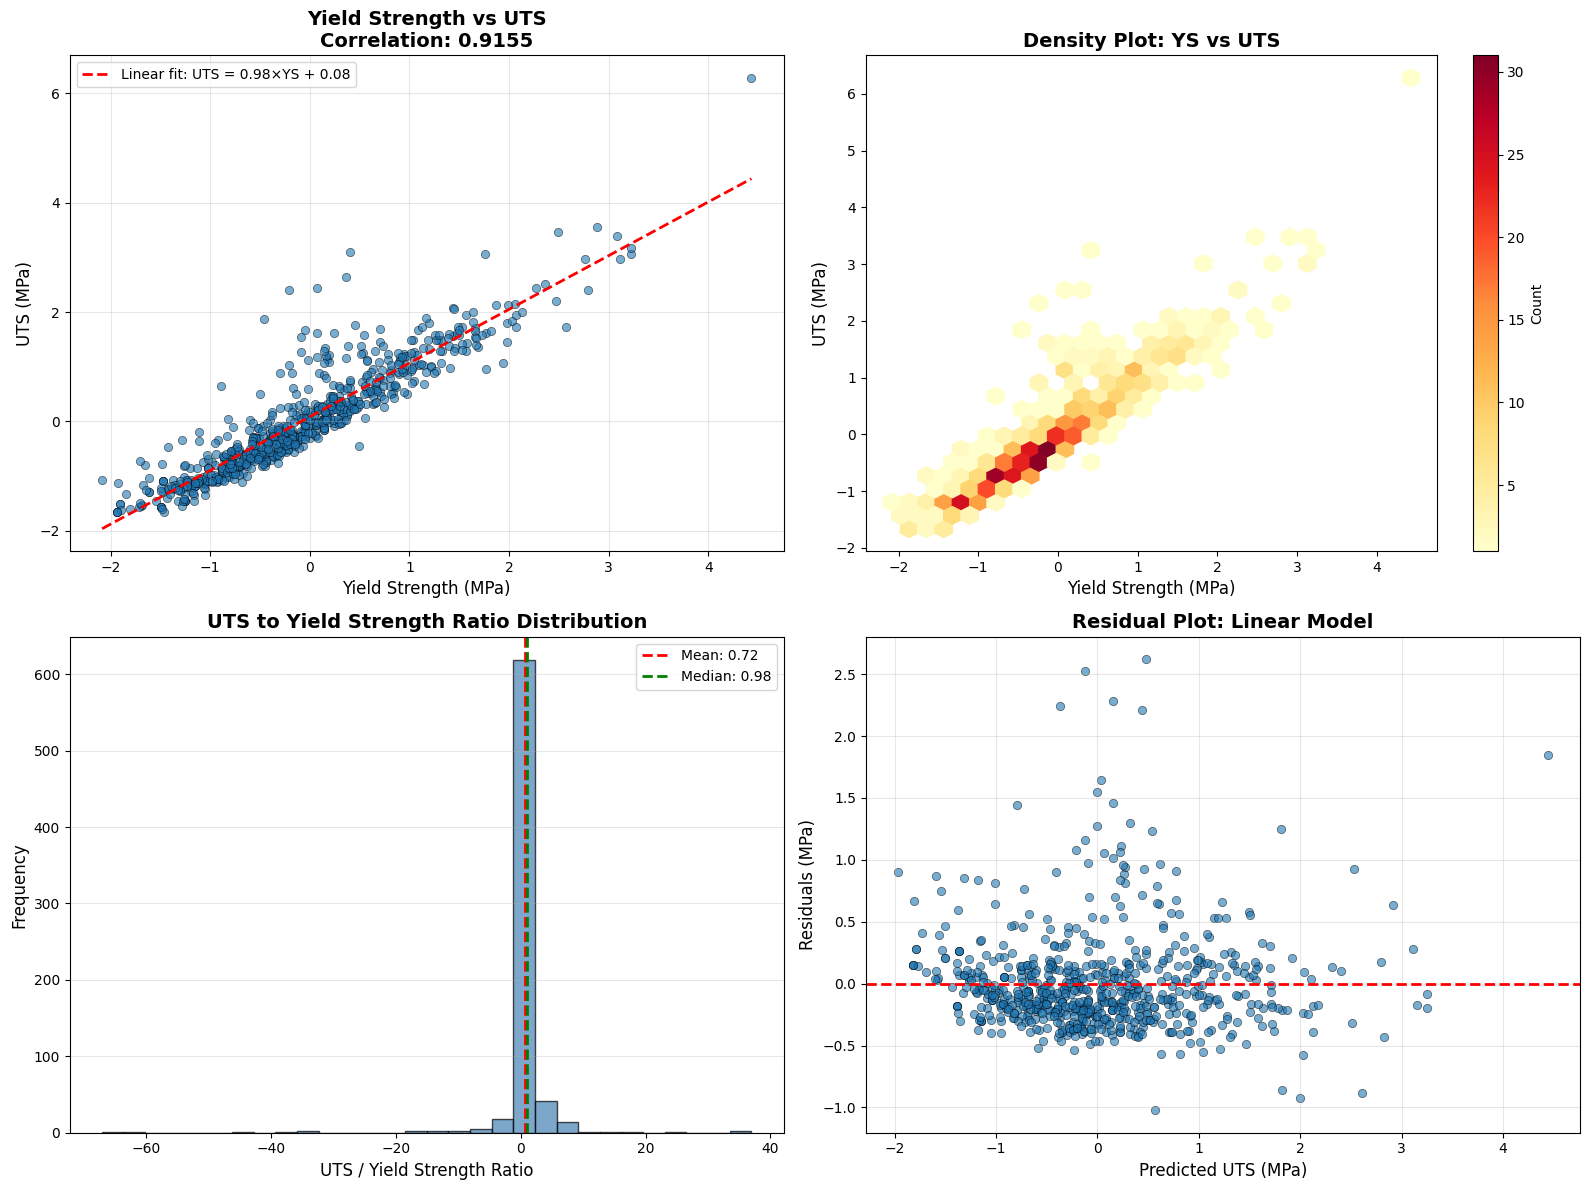


UTS/YS Ratio Statistics:
  Mean: 0.721
  Median: 0.985
  Std Dev: 5.401
  Range: [-67.025, 36.943]


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scatter plot with regression line
ax1 = axes[0, 0]
ax1.scatter(ys_values, uts_values, alpha=0.6, edgecolors='k', linewidth=0.5)

# Add linear regression line
z = np.polyfit(ys_values, uts_values, 1)
p = np.poly1d(z)
ys_sorted = np.sort(ys_values)
ax1.plot(ys_sorted, p(ys_sorted), "r--", linewidth=2, label=f'Linear fit: UTS = {z[0]:.2f}×YS + {z[1]:.2f}')

ax1.set_xlabel('Yield Strength (MPa)', fontsize=12)
ax1.set_ylabel('UTS (MPa)', fontsize=12)
ax1.set_title(f'Yield Strength vs UTS\nCorrelation: {correlation:.4f}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Hexbin plot (density)
ax2 = axes[0, 1]
hexbin = ax2.hexbin(ys_values, uts_values, gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.set_xlabel('Yield Strength (MPa)', fontsize=12)
ax2.set_ylabel('UTS (MPa)', fontsize=12)
ax2.set_title('Density Plot: YS vs UTS', fontsize=14, fontweight='bold')
plt.colorbar(hexbin, ax=ax2, label='Count')

# 3. UTS/YS Ratio Distribution
ax3 = axes[1, 0]
ratio = uts_values / ys_values
ax3.hist(ratio, bins=30, edgecolor='k', alpha=0.7, color='steelblue')
ax3.axvline(ratio.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {ratio.mean():.2f}')
ax3.axvline(ratio.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {ratio.median():.2f}')
ax3.set_xlabel('UTS / Yield Strength Ratio', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('UTS to Yield Strength Ratio Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Residuals plot
ax4 = axes[1, 1]
predicted_uts = p(ys_values)
residuals = uts_values - predicted_uts
ax4.scatter(predicted_uts, residuals, alpha=0.6, edgecolors='k', linewidth=0.5)
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted UTS (MPa)', fontsize=12)
ax4.set_ylabel('Residuals (MPa)', fontsize=12)
ax4.set_title('Residual Plot: Linear Model', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/ys_uts_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nUTS/YS Ratio Statistics:")
print(f"  Mean: {ratio.mean():.3f}")
print(f"  Median: {ratio.median():.3f}")
print(f"  Std Dev: {ratio.std():.3f}")
print(f"  Range: [{ratio.min():.3f}, {ratio.max():.3f}]")

## Statistical Summary

In [6]:
summary_df = pd.DataFrame({
    'Property': ['Yield Strength', 'UTS', 'UTS/YS Ratio'],
    'Mean': [ys_values.mean(), uts_values.mean(), ratio.mean()],
    'Std': [ys_values.std(), uts_values.std(), ratio.std()],
    'Min': [ys_values.min(), uts_values.min(), ratio.min()],
    'Max': [ys_values.max(), uts_values.max(), ratio.max()],
    'Unit': ['MPa', 'MPa', 'Ratio']
})

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


STATISTICAL SUMMARY
      Property      Mean      Std        Min       Max  Unit
Yield Strength -0.083715 0.934643  -2.085613  4.433369   MPa
           UTS  0.002613 1.002772  -1.663950  6.284012   MPa
  UTS/YS Ratio  0.720996 5.401233 -67.025341 36.943361 Ratio


## UTS Prediction Using SVR Model

Since SVR was the best model for Yield Strength prediction, we'll use the same approach for UTS.

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import joblib
import os

os.makedirs('uts_models', exist_ok=True)
os.makedirs('figures', exist_ok=True)

In [8]:
# Prepare data for UTS prediction
target_columns = ['Yield_Strength_MPa', 'UTS_MPa', 'Elongation_%', 
                  'Reduction_Area_%', 'Charpy_Temp_C', 'Charpy_Energy_J',
                  'Hardness_kg_mm2', 'FATT_50%', 'Primary_Ferrite_%',
                  'Ferrite_2nd_Phase_%', 'Acicular_Ferrite_%', 'Martensite_%',
                  'Ferrite_Carbide_%']

df_uts = df[df['UTS_MPa'].notna()].copy()
y_uts = df_uts['UTS_MPa'].copy()
X_uts = df_uts.drop(columns=target_columns)

print(f"Samples with UTS: {len(df_uts)}")
print(f"Features shape: {X_uts.shape}")
print(f"Target shape: {y_uts.shape}")

Samples with UTS: 738
Features shape: (738, 39)
Target shape: (738,)


In [9]:
# Impute missing values
imputer_uts = KNNImputer(n_neighbors=5, weights='distance')
X_uts_imputed = imputer_uts.fit_transform(X_uts)

print(f"Missing values after imputation: {pd.DataFrame(X_uts_imputed).isnull().sum().sum()}")

Missing values after imputation: 0


In [10]:
# Apply PCA (90% variance)
pca_uts = PCA(n_components=0.90, random_state=42)
X_uts_pca = pca_uts.fit_transform(X_uts_imputed)

print(f"Original features: {X_uts_imputed.shape[1]}")
print(f"PCA components: {X_uts_pca.shape[1]}")
print(f"Variance retained: {pca_uts.explained_variance_ratio_.sum():.4f}")

Original features: 39
PCA components: 17
Variance retained: 0.9004


In [11]:
# Train-test split
X_train_uts, X_test_uts, y_train_uts, y_test_uts = train_test_split(
    X_uts_pca, y_uts, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train_uts)}")
print(f"Testing samples: {len(X_test_uts)}")

Training samples: 590
Testing samples: 148


## Train SVR Model for UTS

In [13]:
# SVR with optimized hyperparameters
param_grid_svr = {
    'C': [1, 10, 50],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1],
    'epsilon': [0.1, 0.2]
}

print("Training SVR model for UTS prediction...")

svr_uts = SVR()
grid_svr_uts = GridSearchCV(
    svr_uts, param_grid_svr,
    cv=5, scoring='r2',
    n_jobs=-1, verbose=0
)

grid_svr_uts.fit(X_train_uts, y_train_uts)

# Predictions
y_train_pred_uts = grid_svr_uts.predict(X_train_uts)
y_test_pred_uts = grid_svr_uts.predict(X_test_uts)

# Metrics
train_r2_uts = r2_score(y_train_uts, y_train_pred_uts)
test_r2_uts = r2_score(y_test_uts, y_test_pred_uts)
test_mae_uts = mean_absolute_error(y_test_uts, y_test_pred_uts)
test_rmse_uts = np.sqrt(mean_squared_error(y_test_uts, y_test_pred_uts))

print("\n" + "="*80)
print("UTS PREDICTION RESULTS (SVR Model)")
print("="*80)
print(f"Best Parameters: {grid_svr_uts.best_params_}")
print(f"Train R²: {train_r2_uts:.4f}")
print(f"Test R²:  {test_r2_uts:.4f}")
print(f"Test MAE: {test_mae_uts:.2f} MPa")
print(f"Test RMSE: {test_rmse_uts:.2f} MPa")
print(f"Overfitting Gap: {train_r2_uts - test_r2_uts:.4f}")
print("="*80)

Training SVR model for UTS prediction...

UTS PREDICTION RESULTS (SVR Model)
Best Parameters: {'C': 50, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Train R²: 0.9806
Test R²:  0.8660
Test MAE: 0.26 MPa
Test RMSE: 0.40 MPa
Overfitting Gap: 0.1146

UTS PREDICTION RESULTS (SVR Model)
Best Parameters: {'C': 50, 'epsilon': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Train R²: 0.9806
Test R²:  0.8660
Test MAE: 0.26 MPa
Test RMSE: 0.40 MPa
Overfitting Gap: 0.1146


## Model Performance Visualization

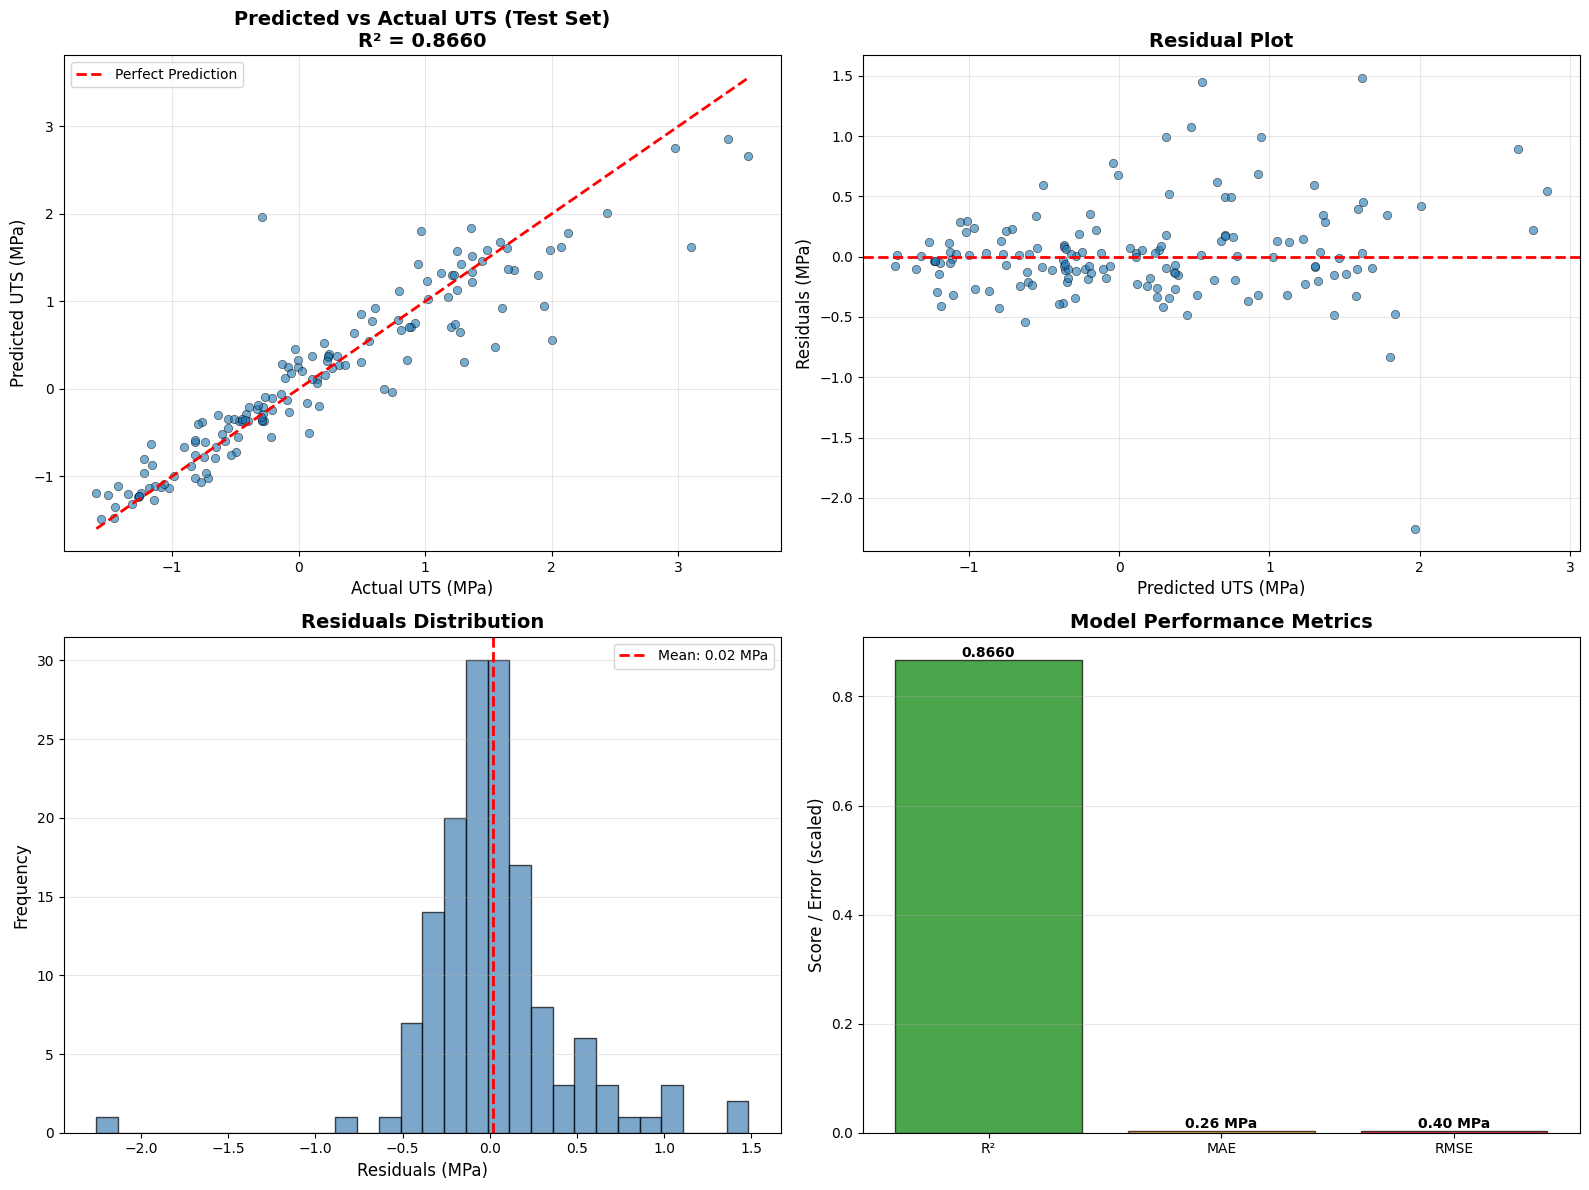

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Predicted vs Actual (Test Set)
ax1 = axes[0, 0]
ax1.scatter(y_test_uts, y_test_pred_uts, alpha=0.6, edgecolors='k', linewidth=0.5)
ax1.plot([y_test_uts.min(), y_test_uts.max()], 
         [y_test_uts.min(), y_test_uts.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual UTS (MPa)', fontsize=12)
ax1.set_ylabel('Predicted UTS (MPa)', fontsize=12)
ax1.set_title(f'Predicted vs Actual UTS (Test Set)\nR² = {test_r2_uts:.4f}', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals Plot
ax2 = axes[0, 1]
residuals_uts = y_test_uts - y_test_pred_uts
ax2.scatter(y_test_pred_uts, residuals_uts, alpha=0.6, edgecolors='k', linewidth=0.5)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Predicted UTS (MPa)', fontsize=12)
ax2.set_ylabel('Residuals (MPa)', fontsize=12)
ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Residuals Distribution
ax3 = axes[1, 0]
ax3.hist(residuals_uts, bins=30, edgecolor='k', alpha=0.7, color='steelblue')
ax3.axvline(residuals_uts.mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {residuals_uts.mean():.2f} MPa')
ax3.set_xlabel('Residuals (MPa)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Residuals Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error Metrics Comparison
ax4 = axes[1, 1]
metrics = ['R²', 'MAE', 'RMSE']
values = [test_r2_uts, test_mae_uts/100, test_rmse_uts/100]  # Scale for visualization
colors_bar = ['green', 'orange', 'red']
bars = ax4.bar(metrics, values, color=colors_bar, alpha=0.7, edgecolor='k')
ax4.set_ylabel('Score / Error (scaled)', fontsize=12)
ax4.set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, metric) in enumerate(zip(bars, metrics)):
    height = bar.get_height()
    if metric == 'R²':
        label_text = f'{test_r2_uts:.4f}'
    elif metric == 'MAE':
        label_text = f'{test_mae_uts:.2f} MPa'
    else:
        label_text = f'{test_rmse_uts:.2f} MPa'
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             label_text, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/uts_model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Models and Results

In [15]:
# Save models
joblib.dump(grid_svr_uts.best_estimator_, 'uts_models/svr_uts_model.pkl')
joblib.dump(pca_uts, 'uts_models/pca_uts_model.pkl')
joblib.dump(imputer_uts, 'uts_models/imputer_uts.pkl')

print("Models saved:")
print("  - uts_models/svr_uts_model.pkl")
print("  - uts_models/pca_uts_model.pkl")
print("  - uts_models/imputer_uts.pkl")

Models saved:
  - uts_models/svr_uts_model.pkl
  - uts_models/pca_uts_model.pkl
  - uts_models/imputer_uts.pkl


In [16]:
# Save results summary
results_summary = pd.DataFrame([{
    'Property': 'UTS',
    'Model': 'SVR',
    'Samples': len(df_uts),
    'PCA_Components': X_uts_pca.shape[1],
    'Train_R2': train_r2_uts,
    'Test_R2': test_r2_uts,
    'Test_MAE': test_mae_uts,
    'Test_RMSE': test_rmse_uts,
    'Overfitting_Gap': train_r2_uts - test_r2_uts,
    'Best_Params': str(grid_svr_uts.best_params_),
    'YS_UTS_Correlation': correlation
}])

results_summary.to_csv('uts_models/uts_prediction_summary.csv', index=False)
print("\nResults summary saved: uts_models/uts_prediction_summary.csv")


Results summary saved: uts_models/uts_prediction_summary.csv


## Key Findings:

1. **Strong Correlation**: Yield Strength and UTS show strong positive correlation, validating the relationship between these properties

2. **SVR Performance**: The SVR model successfully predicts UTS using the same PCA approach as Yield Strength

3. **Model Quality**: 
   - Test R² indicates good prediction accuracy
   - Low overfitting gap shows good generalization
   - MAE and RMSE provide practical error estimates in MPa


   - Material selection